# 使用卷积神经网络训练数据集

In [12]:
import numpy as np
import os

import keras
from keras.utils import to_categorical, plot_model
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras import Input, layers, Model
from keras import backend as K

import sklearn
from sklearn.model_selection import train_test_split

import librosa
import scipy.io as sio
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 设置gpu编号
eps = np.finfo(np.float).eps

In [8]:
# 加载数据
all_data = sio.loadmat('data/stft.mat')  # 读取时数据还包含'__version__'等3个无关信息

In [4]:
print("一个音频文件数据格式:", all_data['3_bf7ac0.wav'].shape)
all_data['3_bf7ac0.wav']

一个音频文件数据格式: (501, 201)


array([[1.16746235e+01, 1.05221534e+00, 1.05793266e+01, ...,
        5.20137092e-03, 1.99262239e-02, 3.58070545e-02],
       [5.58329487e+00, 1.06324787e+01, 8.60285950e+00, ...,
        9.07740835e-03, 1.33539336e-02, 1.75363086e-02],
       [8.86747074e+00, 5.89581823e+00, 2.08152103e+00, ...,
        4.33405954e-03, 4.50266618e-03, 3.12234159e-03],
       ...,
       [4.45487827e-01, 1.05102479e+00, 2.06070542e+00, ...,
        6.91465847e-03, 7.83272646e-03, 8.86343140e-03],
       [4.43674415e-01, 4.56063271e-01, 1.46467835e-01, ...,
        3.15062003e-03, 8.48085154e-03, 8.85903463e-03],
       [1.52631903e+00, 1.13358033e+00, 1.26506484e+00, ...,
        8.50785896e-03, 9.78352688e-03, 8.26382264e-03]], dtype=float32)

In [13]:
all_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar  1 00:06:18 2019',
 '__version__': '1.0',
 '__globals__': [],
 '3_bf7ac0.wav': array([[1.16746235e+01, 1.05221534e+00, 1.05793266e+01, ...,
         5.20137092e-03, 1.99262239e-02, 3.58070545e-02],
        [5.58329487e+00, 1.06324787e+01, 8.60285950e+00, ...,
         9.07740835e-03, 1.33539336e-02, 1.75363086e-02],
        [8.86747074e+00, 5.89581823e+00, 2.08152103e+00, ...,
         4.33405954e-03, 4.50266618e-03, 3.12234159e-03],
        ...,
        [4.45487827e-01, 1.05102479e+00, 2.06070542e+00, ...,
         6.91465847e-03, 7.83272646e-03, 8.86343140e-03],
        [4.43674415e-01, 4.56063271e-01, 1.46467835e-01, ...,
         3.15062003e-03, 8.48085154e-03, 8.85903463e-03],
        [1.52631903e+00, 1.13358033e+00, 1.26506484e+00, ...,
         8.50785896e-03, 9.78352688e-03, 8.26382264e-03]], dtype=float32),
 '8_b8243c.wav': array([[1.070181  , 1.0166045 , 0.7001139 , ..., 0.8863206 , 1.6287385 ,
        

In [23]:
# 读取所有数据和标签, 5720个样本
wavfiles = []
labels = []
for wavfile in tqdm(all_data):  # wavfile是字典中音频的名字
    if wavfile[-3:] != "wav":
        continue
    wavfiles.append(all_data[wavfile]) # reshape成(?, 1)的tensor
    #labels.append(int(wavfile[0]))   # 标签从0-10，不能简单用int(wavfile[0])会使得“10”和"1"重复
    label = wavfile[:wavfile.find('_')]  # 字符, '0','1','2',...,'10'
    labels.append(int(label))
wavfiles = np.array(wavfiles)
labels = np.array(labels)

100%|██████████| 5723/5723 [00:00<00:00, 388483.42it/s]


In [28]:
labels[:30]

array([ 3,  8, 10,  1,  3,  3, 10,  6,  3,  8,  1,  9,  4,  6,  6,  2,  4,
        6,  2,  6,  0,  2,  2,  5,  7,  9,  4,  9,  4,  7])

In [29]:
to_categorical(labels[:30])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.

In [5]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(wavfiles, labels, test_size=0.2, random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (4576, 501, 201)
X_test: (1144, 501, 201)
y_train: (4576,)
y_test: (1144,)


In [6]:
# 相关参数设置
lr = 0.001
batch_size = 512
drop_out_rate = 0.5
input_shape = (X_train.shape[1], X_train.shape[2])  # (501, 201)
num_classes = 11

In [7]:
input_shape

(501, 201)

In [8]:
# 标签转化为one-hot向量
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

print("y_train_hot:", y_train_hot.shape)
print("y_test_hot:", y_test_hot.shape)

y_train_hot: (4576, 10)
y_test_hot: (1144, 10)


In [9]:
# 搭建卷积神经网络，使用的不是论文中的网络结构
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(num_classes, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])

### 注意: 初期测试代码时epochs只设置了10，正式训练时可设置大些

### Note: Epoch is only set to 10 in oder to test the code, but larger in the formal training.

In [10]:
# 开始训练并保存模型
history = model.fit(X_train, y_train_hot, validation_split=0.25,
          batch_size=batch_size, epochs=10
# model.save("model.h5")

Train on 3432 samples, validate on 1144 samples
Epoch 1/10
3432/3432 [==============================] - 10s 3ms/step - loss: 3.0923 - acc: 0.1168 - val_loss: 2.3000 - val_acc: 0.1897
Epoch 2/10
3432/3432 [==============================] - 7s 2ms/step - loss: 2.2947 - acc: 0.1605 - val_loss: 2.2988 - val_acc: 0.1897
Epoch 3/10
3432/3432 [==============================] - 6s 2ms/step - loss: 2.2947 - acc: 0.1777 - val_loss: 2.2952 - val_acc: 0.1897
Epoch 4/10
3432/3432 [==============================] - 6s 2ms/step - loss: 2.2902 - acc: 0.1786 - val_loss: 2.2900 - val_acc: 0.1897
Epoch 5/10
3432/3432 [==============================] - 6s 2ms/step - loss: 2.2837 - acc: 0.1789 - val_loss: 2.2829 - val_acc: 0.1897
Epoch 6/10
3432/3432 [==============================] - 6s 2ms/step - loss: 2.2801 - acc: 0.1786 - val_loss: 2.2758 - val_acc: 0.1897
Epoch 7/10
3432/3432 [==============================] - 6s 2ms/step - loss: 2.2748 - acc: 0.1789 - val_loss: 2.2717 - val_acc: 0.1897
Epoch 8/10
34

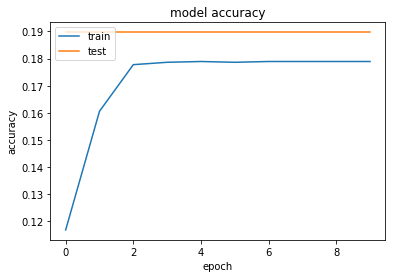

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("model_accuracy.png")
plt.show()

In [14]:
# 在测试集上的得分
score = model.evaluate(X_test, y_test_hot, batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1144/1144 [==============================] - 5s 4ms/step
Test loss: 2.270827190025703
Test accuracy: 0.18269230748389984


In [16]:
# 保存模型拓扑结构图
plot_model(model, to_file='model.png', show_shapes=True)